# San Francisco Crime Dataset Use Case. Module 5. MAABD

Created on Sat Dec  2 19:05:14 2017 

#### @author: Juan Miguel González Álvarez

In [259]:
#Importing required packages
import re
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
from IPython.core.display import display, HTML
from IPython.display import HTML
import json

import sys
sys.path.insert(0,'..')
import folium
print (folium.__file__)
print (folium.__version__)
from matplotlib.colors import Normalize, rgb2hex

import pymongo
from pymongo import MongoClient, GEO2D

C:\Anaconda3\lib\site-packages\folium\__init__.py
0.5.0


#### First data exploration

In [260]:
# Data import from csv
# We have imported the data from The Police department San Francisco Crime Dataset to a dataframe called total_crime.
# As Dataframe is very heavy to work with it, we will only take first 600000 rows.

total_crime = pd.read_csv('F:\\CaseUseIData\\Map_of_Police_Department_Incidents.csv')
print(total_crime.shape)
d_crime=total_crime.head(600000)

(2153188, 12)


In [261]:
# Data cleaning. Transform Data from string to date type and delta date

date=pd.to_datetime(d_crime['Date'])
print(date.min())
print(date.max())

2003-01-01 00:00:00
2017-04-19 00:00:00


In [262]:
# Create a new colum "days" with timedelta format

t_delta=(date-date.min()).astype('timedelta64[D]')
d_crime['days']=t_delta
d_crime.head(1)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


IncidntNum      Category       Descript DayOfWeek                    Date  \
0   150060275  NON-CRIMINAL  LOST PROPERTY    Monday  01/19/2015 12:00:00 AM   

    Time PdDistrict Resolution                Address           X          Y  \
0  14:00    MISSION       NONE  18TH ST / VALENCIA ST -122.421582  37.761701   

                               Location    days  
0  (37.7617007179518, -122.42158168137)  4401.0

In [263]:
# Plotting bargraph
# We have created a plot bargraph function to show the number of reports existing by 'cat'.
# In addition we have modified the function to create a new functionality, so we can choose which colour you prefer on the plot.

def plotdat(data,cat,c):   
    l=data.groupby(cat).size()
    l.sort_values(ascending=True).sort_index()
    fig=plt.figure(figsize=(10,5))
    plt.yticks(fontsize=8)
    l.plot(kind='bar',fontsize=12,color=c)
    plt.xlabel('')
    plt.ylabel('Number of reports',fontsize=10)

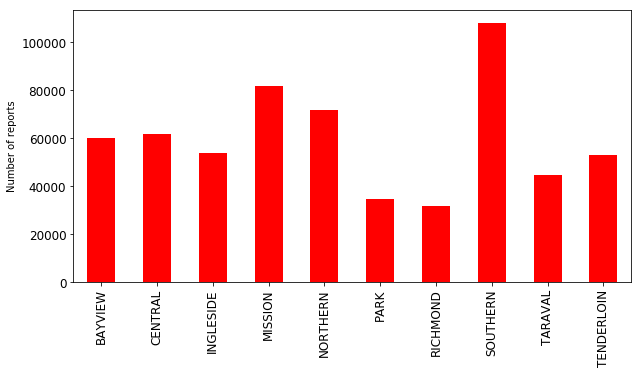

In [264]:
# Here, we have a plot bargraph where we show the number of reports by District.

plotdat(d_crime,'PdDistrict','r')

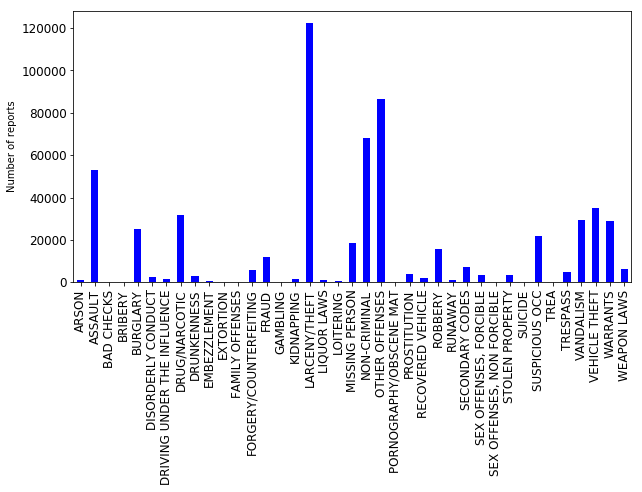

In [265]:
# In this plot you can see the number of reports by Categories.

plotdat(d_crime,'Category','b')

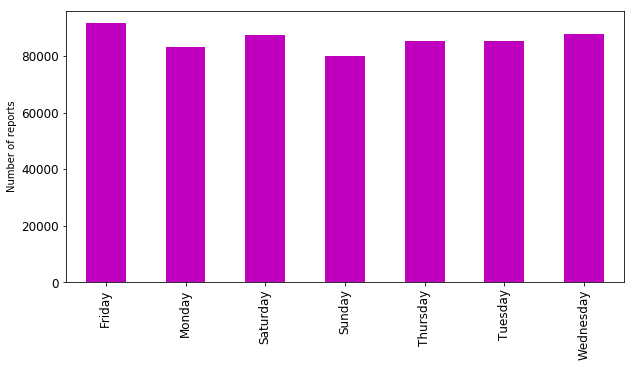

In [266]:
# another plot where you can see the number of reports by day of week. Notice on Friday is the day with more numbers of reports.

plotdat(d_crime,'DayOfWeek','m')

In [267]:
# Now, we get a total number of Descript incidents.

l=d_crime.groupby('Descript').size()
l.sort_values()
print(l.shape)

(867,)


In [268]:
# Heatmap and hierarchical clustering

def types_districts(d_crime,per):
    
    # Group by crime type and district 
    hoods_per_type=d_crime.groupby('Descript').PdDistrict.value_counts(sort=True)
    t=hoods_per_type.unstack().fillna(0)
    
    # Sort by hood sum
    hood_sum=t.sum(axis=0)
    hood_sum.sort_values(ascending=False)
    t=t[hood_sum.index]
    
    # Filter by crime per district
    crime_sum=t.sum(axis=1)
    crime_sum.sort_values(ascending=False)
    
    # Large number, so let's slice the data.
    p=np.percentile(crime_sum,per)
    ix=crime_sum[crime_sum>p]
    t=t.loc[ix.index]
    return t

In [269]:
t=types_districts(d_crime,98)

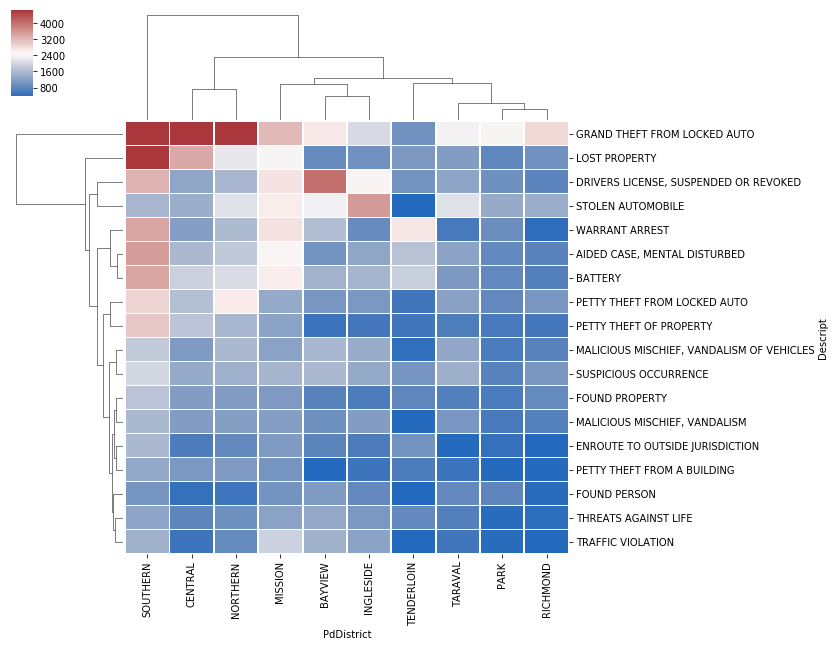

In [270]:
# Here, for this plot we are going to use the parameter: robust : bool,  is an optional parameter but we must use it,
# because the colormap range is computed with robust quantiles instead of the extreme values.
# Furthermore,  we have modified the structure and colours of the plot, so we can see it cleaner.

sns.clustermap(t,cmap="vlag", robust=True,linewidths=.75) 

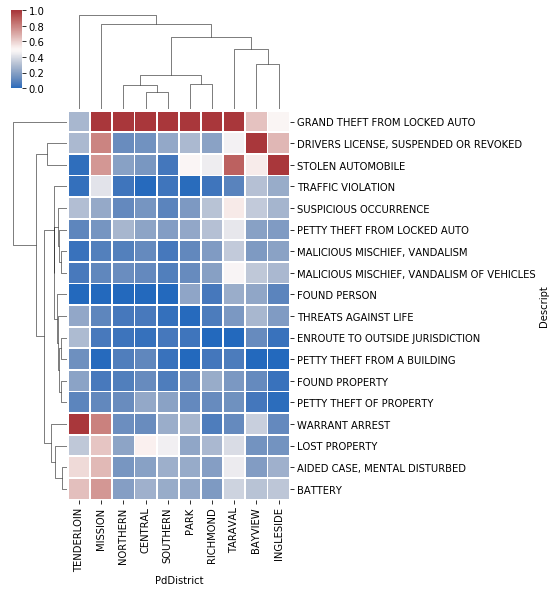

In [271]:
# It is required to scale dimensions
# Standardize the data within the columns (scale=1)
# Sometimes, a few values in your input have extreme values. 
# In a heatmap, this has as an effect to make every other cell the same color, what is not desired. 
# The clustermap function allows you to avoid that with the ‘robust‘ argument. Here is an example with (left) and without (right) this option.

# In this case we will use the parameter: z_score, is a optional parameter but allows us calculate z-scores for the rows or 
# the columns. Z scores are: z = (x - mean)/std, so values in each row (column) will get the mean of the row (column)
# subtracted, then divided by the standard deviation of the row (column). This ensures that each row (column) has mean of 0 and variance of 1.
# Furthermore,  we have modified some parameters of the plot to practice.

sns.clustermap(t,standard_scale=1,cmap="vlag", robust=True,linewidths=.75,figsize=(5,9))

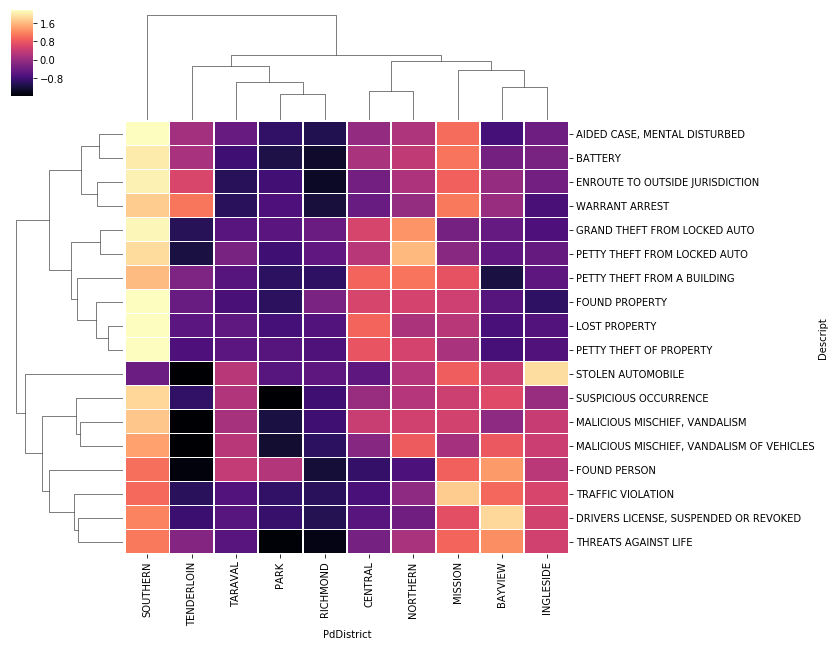

In [272]:
# Normalize the data within the rows s_score=0
# In this case we will include other parameter called z_score, with it we can normalize the data so that
# we can see more uniform and soften outlined data. calculate z-scores for the rows or the columns.
# Z scores are: z = (x - mean)/std, so values in each row (column) will get the mean of the row (column) subtracted,
# then divided by the standard deviation of the row (column). This ensures that each row (column) has mean of 0 and variance of 1.
# Furthermore,  we have modified the structure and colours of the plot, so we can see it cleaner.

sns.clustermap(t,z_score=0,cmap="magma", robust=True,linewidths=.75)

#### Let's drill down onto one

###### Mongo Database connection and store data______________________________________________________________________________

In [273]:
print('Mongo version', pymongo.__version__)
client = MongoClient('localhost', 27017)
db = client.test
collection = db.crimesf

Mongo version 3.4.0


In [274]:
#Clean collection 
collection.drop()

In [275]:
#Import data into the database. First, transform to JSON records
records = json.loads(d_crime.to_json(orient='records'))
collection.delete_many({})
collection.insert_many(records)

In [276]:
#Check if we can access the data from the MongoDB.
cursor = collection.find().sort('Category',pymongo.ASCENDING).limit(3)
for doc in cursor:
    print(doc)

{'_id': ObjectId('5a58a9781c87e2096cbbc8cb'), 'IncidntNum': 140009459, 'Category': 'ARSON', 'Descript': 'ARSON', 'DayOfWeek': 'Saturday', 'Date': '01/04/2014 12:00:00 AM', 'Time': '03:52', 'PdDistrict': 'NORTHERN', 'Resolution': 'ARREST, BOOKED', 'Address': 'SACRAMENTO ST / POLK ST', 'X': -122.4208746324, 'Y': 37.7914943052, 'Location': '(37.7914943051906, -122.420874632415)', 'days': 4021.0}
{'_id': ObjectId('5a58a9781c87e2096cbbc98d'), 'IncidntNum': 150100081, 'Category': 'ARSON', 'Descript': 'ARSON OF AN INHABITED DWELLING', 'DayOfWeek': 'Monday', 'Date': '02/02/2015 12:00:00 AM', 'Time': '10:05', 'PdDistrict': 'MISSION', 'Resolution': 'ARREST, BOOKED', 'Address': '500 Block of VALENCIA ST', 'X': -122.4218764885, 'Y': 37.7640888945, 'Location': '(37.7640888944532, -122.421876488492)', 'days': 4415.0}
{'_id': ObjectId('5a58a9781c87e2096cbbc9cc'), 'IncidntNum': 150100677, 'Category': 'ARSON', 'Descript': 'ARSON OF A VEHICLE', 'DayOfWeek': 'Monday', 'Date': '02/02/2015 12:00:00 AM', 'T

In [277]:
# stablish a pipeline to select all rows matching attribute "Category" = "ASSAULT"
pipeline = [
        {"$match": {"Category":"ASSAULT"}},
]

In [278]:
#Query the collection with the pipeline filter. 
aggResult = collection.aggregate(pipeline)
df2 = pd.DataFrame(list(aggResult))
df2.head()

Address Category                    Date DayOfWeek  \
0  300 Block of LEAVENWORTH ST  ASSAULT  02/01/2015 12:00:00 AM    Sunday   
1        PACIFIC AV / GRANT AV  ASSAULT  02/01/2015 12:00:00 AM    Sunday   
2        PACIFIC AV / GRANT AV  ASSAULT  02/01/2015 12:00:00 AM    Sunday   
3        400 Block of ELLIS ST  ASSAULT  02/01/2015 12:00:00 AM    Sunday   
4     2000 Block of MISSION ST  ASSAULT  02/01/2015 12:00:00 AM    Sunday   

                               Descript  IncidntNum  \
0  AGGRAVATED ASSAULT WITH BODILY FORCE   150098210   
1  AGGRAVATED ASSAULT WITH BODILY FORCE   150098414   
2         BATTERY WITH SERIOUS INJURIES   150098414   
3  AGGRAVATED ASSAULT WITH BODILY FORCE   150098420   
4           BATTERY OF A POLICE OFFICER   150098458   

                                Location  PdDistrict      Resolution   Time  \
0  (37.7841907151119, -122.414406029855)  TENDERLOIN            NONE  15:45   
1  (37.7969028838908, -122.406831986427)     CENTRAL  ARREST, BOOKED  17:05   
2  (37.7969028838908, -122.406831986427)     CENTRAL  ARREST, BOOKED  17:05   
3   (37.784696907904, -122.413609328985)  TENDERLOIN  ARREST, BOOKED  17:10   
4   (37.764228935718, -122.419520367886)     MISSION  ARREST, BOOKED  16:56   

            X          Y                       _id    days  
0 -122.414406  37.784191  5a58a9781c87e2096cbbc8af  4414.0  
1 -122.406832  37.796903  5a58a9781c87e2096cbbc8c3  4414.0  
2 -122.406832  37.796903  5a58a9781c87e2096cbbc8c4  4414.0  
3 -122.413609  37.784697  5a58a9781c87e2096cbbc8c6  4414.0  
4 -122.419520  37.764229  5a58a9781c87e2096cbbc8ca  4414.0

In [279]:
#How many rows the collection has?
collection.find({"Category":"ASSAULT"}).count()

53125

In [280]:
# Let's have a look on incidents' descriptions
c=df2['Descript'].value_counts()
c.sort_values(ascending=False)
c.head(10)

BATTERY                                          17764
THREATS AGAINST LIFE                              9267
INFLICT INJURY ON COHABITEE                       4932
AGGRAVATED ASSAULT WITH A DEADLY WEAPON           4510
AGGRAVATED ASSAULT WITH BODILY FORCE              3639
BATTERY, FORMER SPOUSE OR DATING RELATIONSHIP     2708
AGGRAVATED ASSAULT WITH A KNIFE                   1734
CHILD ABUSE (PHYSICAL)                             980
BATTERY OF A POLICE OFFICER                        900
BATTERY WITH SERIOUS INJURIES                      747
Name: Descript, dtype: int64

In [281]:
# Organize incidents' descriptions versus Districts where they were detected
def types_districts(d_crime,per):
    
    # Group by crime type and district 
    hoods_per_type=d_crime.groupby('Descript').PdDistrict.value_counts(sort=True)
    t=hoods_per_type.unstack().fillna(0)
    
    # Sort by hood sum
    hood_sum=t.sum(axis=0)
    hood_sum.sort_values(ascending=False)
    t=t[hood_sum.index]
    
    # Filter by crime per district
    crime_sum=t.sum(axis=1)
    crime_sum.sort_values(ascending=False)
    
    # Large number, so let's slice the data.
    p=np.percentile(crime_sum,per)
    ix=crime_sum[crime_sum>p]
    t=t.loc[ix.index]
    return t

In [282]:
# Filter outliers up to 75 percentile
t=types_districts(df2,50)

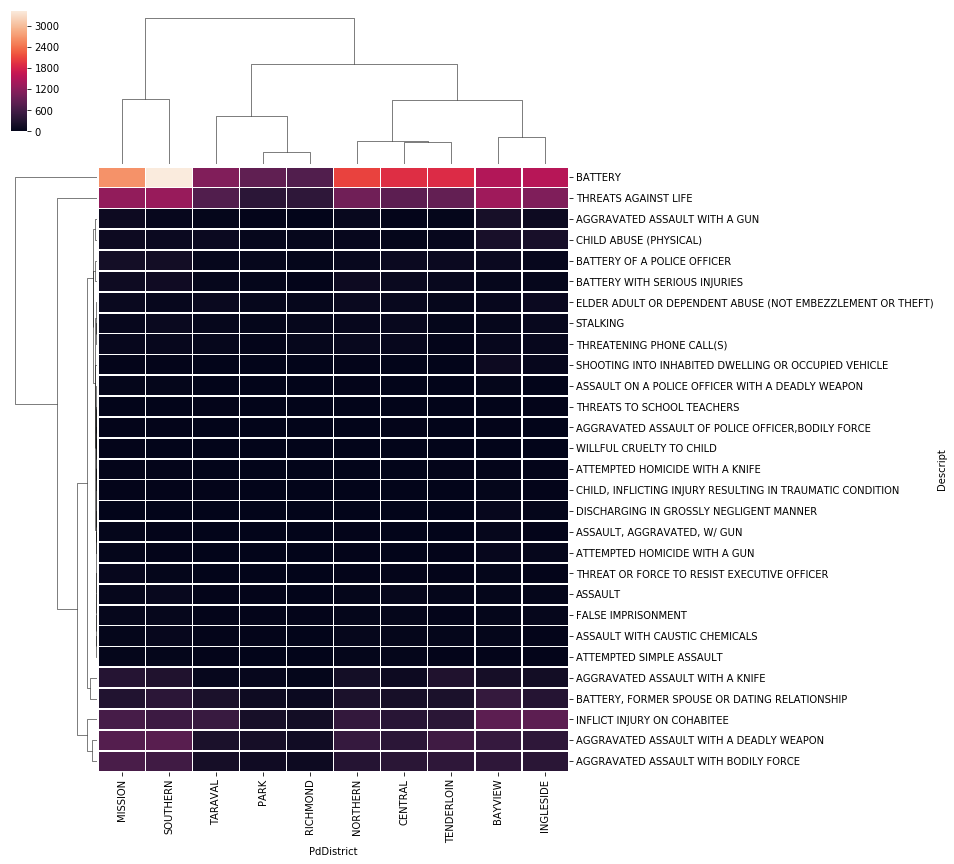

In [283]:
# Inspect data by means of clustermaps
# In this plot we can see some outliers like 'BATTERY' to avoid it we will use the parameter “standard_scale” on the plot below.

sns.clustermap(t,linewidths=0.75,figsize=(10,14))

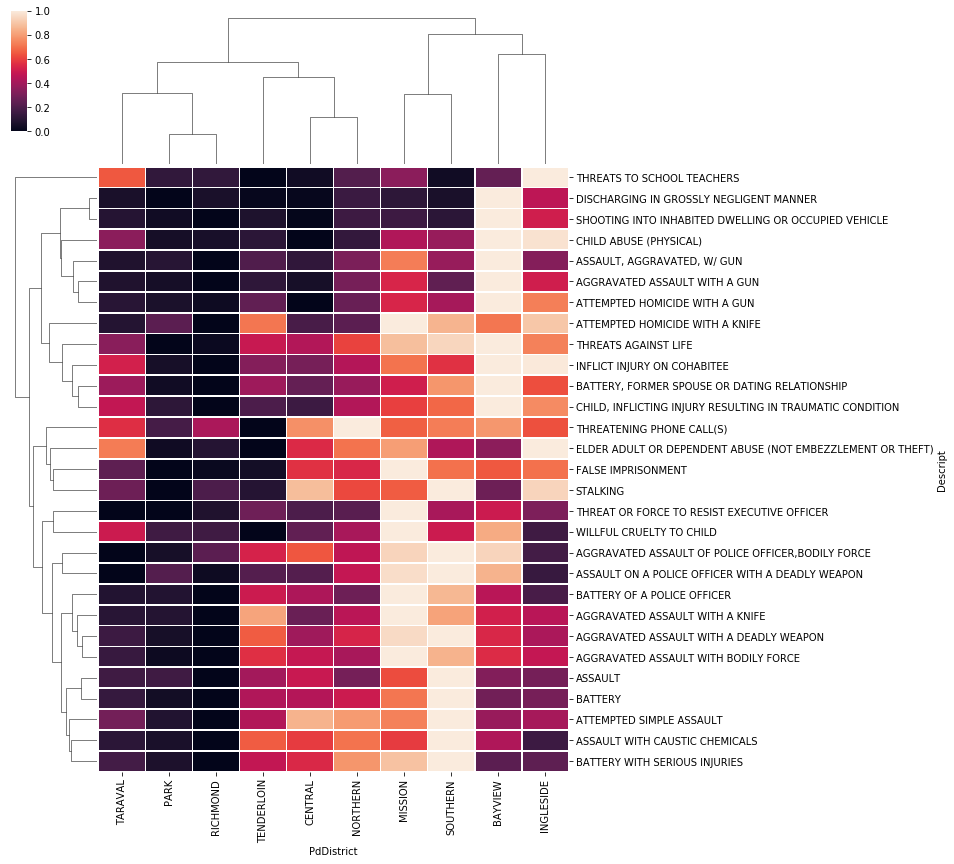

In [284]:
# Here we have used the parameter "standard_scale" for each rows.
# You notice the difference between this plot and the plot above. When we use the parameter “standard_scale” in this plot
# you can appreciate the different colour shades and intensities in every cluster.

sns.clustermap(t,standard_scale=0,linewidths=0.75,figsize=(10,14))

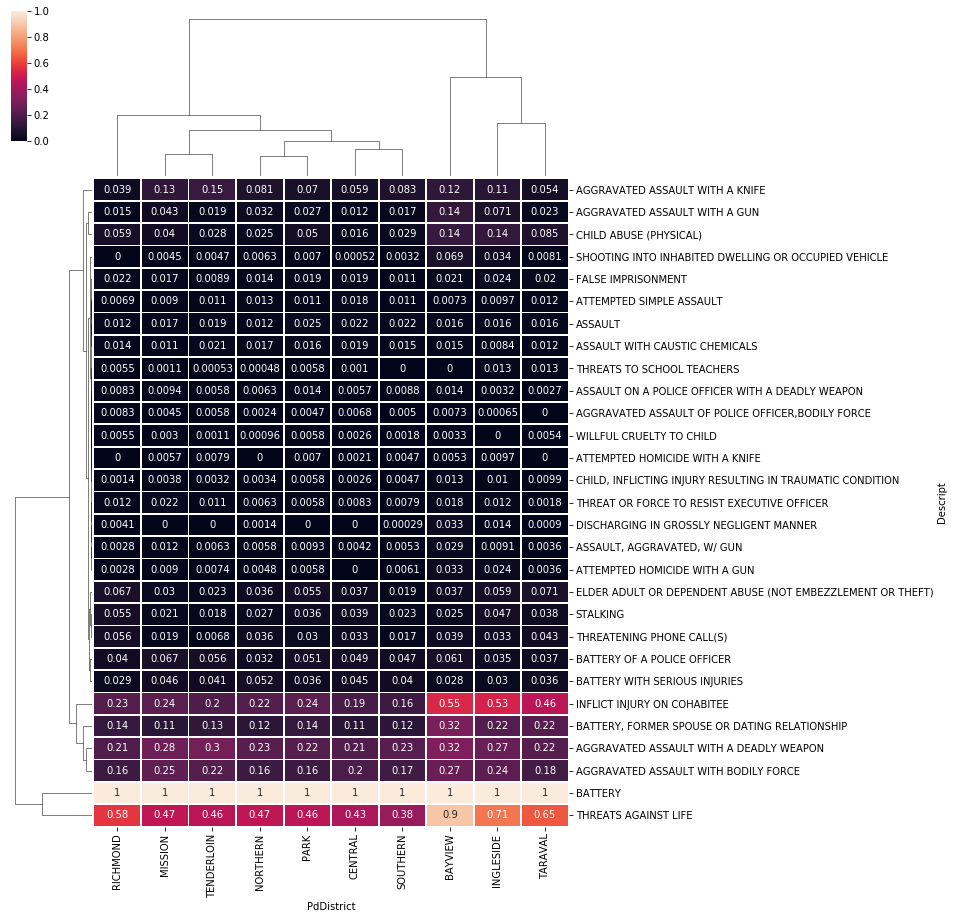

In [285]:
# This is the same plot that above, but we have changed the parameter “standard_scale =1”. It means to work with columns.
# furthermore, We have added a new parameter called “annot”, this will write the data value in each cell. If an array-like
# with the same shape as data, then use this to annotate the heatmap instead of the raw data.

sns.clustermap(t,standard_scale=1, annot=True,linewidths=0.75,figsize=(10,15))

#### Time Series Analysis

In [286]:
# Bin crime by 30 day window. That is, obtain new colum with corresponding months 

df2['Month']=np.floor(df2['days']/30) # Approximate month (30 day window)

In [287]:
# Default

district='All'

In [288]:
def timeseries(dat,per):
    ''' Category grouped by month '''
    
    # Group by crime type and district 
    cat_per_time=dat.groupby('Month').Descript.value_counts(sort=True)
    t=cat_per_time.unstack().fillna(0)
  
    # Filter by crime per district
    crime_sum=t.sum(axis=0)
    crime_sum.sort_values()
    
    # Large number, so let's slice the data.
    p=np.percentile(crime_sum,per)
    ix=crime_sum[crime_sum>p]
    t=t[ix.index]
    
    return t

In [289]:
# We have created a Dataframe wherein you can see the numbers of assaults committed classified by months and description. 
t_all=timeseries(df2,10)

In [290]:
#Find inciden's descriptions related to word patter "DEADLY"
pat = re.compile(r'DEADLY', re.I)

In [291]:
# We do an aggregation query in MongoDB.

pipeline = [
        {"$match": {"Category":"ASSAULT" , 'Descript': {'$regex': pat}}},]


In [292]:
aggResult = collection.aggregate(pipeline)
df3 = pd.DataFrame(list(aggResult))
df3.head()

Address Category                    Date  DayOfWeek  \
0      16TH ST / MISSION ST  ASSAULT  02/01/2015 12:00:00 AM     Sunday   
1  500 Block of BROADWAY ST  ASSAULT  02/01/2015 12:00:00 AM     Sunday   
2   1100 Block of FOLSOM ST  ASSAULT  02/02/2015 12:00:00 AM     Monday   
3   800 Block of BRANNAN ST  ASSAULT  02/03/2015 12:00:00 AM    Tuesday   
4     1400 Block of 32ND AV  ASSAULT  02/04/2015 12:00:00 AM  Wednesday   

                                  Descript  IncidntNum  \
0  AGGRAVATED ASSAULT WITH A DEADLY WEAPON   150099070   
1  AGGRAVATED ASSAULT WITH A DEADLY WEAPON   150099183   
2  AGGRAVATED ASSAULT WITH A DEADLY WEAPON   150100796   
3  AGGRAVATED ASSAULT WITH A DEADLY WEAPON   150103449   
4  AGGRAVATED ASSAULT WITH A DEADLY WEAPON   150108427   

                                Location PdDistrict      Resolution   Time  \
0  (37.7650501214668, -122.419671780296)    MISSION            NONE  21:05   
1  (37.7979466732983, -122.406460643507)    CENTRAL            NONE  22:28   
2   (37.7760967348453, -122.40856429774)   SOUTHERN            NONE  13:38   
3  (37.7721958190345, -122.404385042303)   SOUTHERN  ARREST, BOOKED  10:15   
4   (37.760137271659, -122.490788343316)    TARAVAL  ARREST, BOOKED  15:00   

            X          Y                       _id    days  
0 -122.419672  37.765050  5a58a9781c87e2096cbbc91c  4414.0  
1 -122.406461  37.797947  5a58a9781c87e2096cbbc92d  4414.0  
2 -122.408564  37.776097  5a58a9781c87e2096cbbc9d7  4415.0  
3 -122.404385  37.772196  5a58a9781c87e2096cbbcb17  4416.0  
4 -122.490788  37.760137  5a58a9781c87e2096cbbcd3d  4417.0

In [293]:
deadly = df3.groupby('Descript').size()
s = pd.Series(deadly)

In [294]:
print(s)

Descript
AGGRAVATED ASSAULT WITH A DEADLY WEAPON             4510
ASSAULT ON A POLICE OFFICER WITH A DEADLY WEAPON     172
ATTEMPTED MAYHEM WITH A DEADLY WEAPON                 19
MAYHEM WITH A DEADLY WEAPON                           32
dtype: int64


In [295]:
s = s[s != 1]

In [296]:
deadly_features = list(s.index)

In [297]:
print(deadly_features)

['AGGRAVATED ASSAULT WITH A DEADLY WEAPON', 'ASSAULT ON A POLICE OFFICER WITH A DEADLY WEAPON', 'ATTEMPTED MAYHEM WITH A DEADLY WEAPON', 'MAYHEM WITH A DEADLY WEAPON']


In [298]:
#Let's generate a function to constructu subsets of descriptions according to patterns: KNIFE, WEAPON, FORCE, DEADLY, etc.

def descriptionsAccordingToPattern(pattern):
    pat = re.compile(pattern, re.I)
   
    pipeline = [
            {"$match": {"Category":"ASSAULT" , 'Descript': {'$regex': pat}}},
    ]
    
    aggResult = collection.aggregate(pipeline)
    df3 = pd.DataFrame(list(aggResult))
    assault = df3.groupby('Descript').size()
    s = pd.Series(assault)
    s = s[s != 1] # filter those descriptions with value less equal 1
    features = list(s.index)
    
    return features

In [299]:
# Filter by pattern 'KNIFE'

knife_features = descriptionsAccordingToPattern('KNIFE')

In [300]:
print(knife_features)

['AGGRAVATED ASSAULT ON POLICE OFFICER WITH A KNIFE', 'AGGRAVATED ASSAULT WITH A KNIFE', 'ATTEMPTED HOMICIDE WITH A KNIFE', 'ATTEMPTED MAYHEM WITH A KNIFE', 'MAYHEM WITH A KNIFE']


In [301]:
knife_features = descriptionsAccordingToPattern('KNIFE')
battery_features = descriptionsAccordingToPattern('BATTERY')
weapon_features = descriptionsAccordingToPattern('WEAPON')
abuse_features = descriptionsAccordingToPattern('ABUSE')
force_features = descriptionsAccordingToPattern('FORCE')
chemicals_features = descriptionsAccordingToPattern('DEADLY')
threat_features = descriptionsAccordingToPattern('THREAT')


In [302]:
# Lets use real dates for plotting

days_from_start=pd.Series(t_all.index*30).astype('timedelta64[D]')
dates_for_plot=date.min()+days_from_start
time_labels=dates_for_plot.map(lambda x: str(x.year)+'-'+str(x.month))

In [303]:
# Analytics per assault tipology according to descriptions by months, with absolute values. We've eliminated outliners of 
# the 2016 year.

def assault_analysis(t,district,plot):
    t['KNIFE']=t[knife_features].sum(axis=1)
    t['WEAPON']=t[weapon_features].sum(axis=1)
    t['ABUSE']=t[abuse_features].sum(axis=1)
    t['FORCE']=t[force_features].sum(axis=1)
    t['CHEMICALS']=t[chemicals_features].sum(axis=1)
    t['DEADLY']=t[chemicals_features].sum(axis=1)
    t['THREAT']=t[threat_features].sum(axis=1)
   
    assaults=t[['KNIFE','WEAPON','ABUSE','FORCE','DEADLY','CHEMICALS','THREAT']]
    if plot:
        assaultsh = assaults.head(130)
        assaultsh.index=[int(i) for i in assaultsh.index]
        colors = plt.cm.Spectral(np.linspace(0, 1, assaultsh.shape[1]))
        assaultsh.plot(kind='bar', stacked=True, figsize=(20,5), color=colors, width=0.8, title=district,fontsize=6)
        return assaultsh

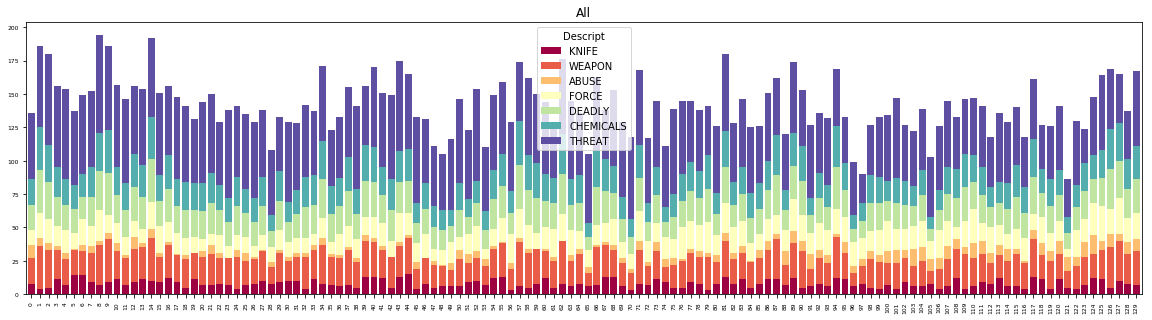

In [304]:
assault_df_all=assault_analysis(t_all,district,True)

In [305]:
# This is the same plot above, but we have normalized the data.

def assault_analysis_rescale(t,district,plot):
    t['KNIFE']=t[knife_features].sum(axis=1)
    t['WEAPON']=t[weapon_features].sum(axis=1)
    t['ABUSE']=t[abuse_features].sum(axis=1)
    t['FORCE']=t[force_features].sum(axis=1)
    t['CHEMICALS']=t[chemicals_features].sum(axis=1)
    t['DEADLY']=t[chemicals_features].sum(axis=1)
    t['THREAT']=t[threat_features].sum(axis=1)

    assaults=t[['KNIFE','WEAPON','ABUSE','FORCE','DEADLY','CHEMICALS','THREAT']]
    if plot:
        assaults=assaults.div(assaults.sum(axis=1),axis=0)
        assaults.index=[int(i) for i in assaults.index]
        colors = plt.cm.RdYlGn(np.linspace(0, 1, assaults.shape[1]))
        colors = plt.cm.Spectral(np.linspace(0, 1, assaults.shape[1]))
        assaults.plot(kind='bar',stacked=True, figsize=(20,5), color=colors, width=1, title=district, legend=True)
        plt.ylim([0,1])
    return assaults

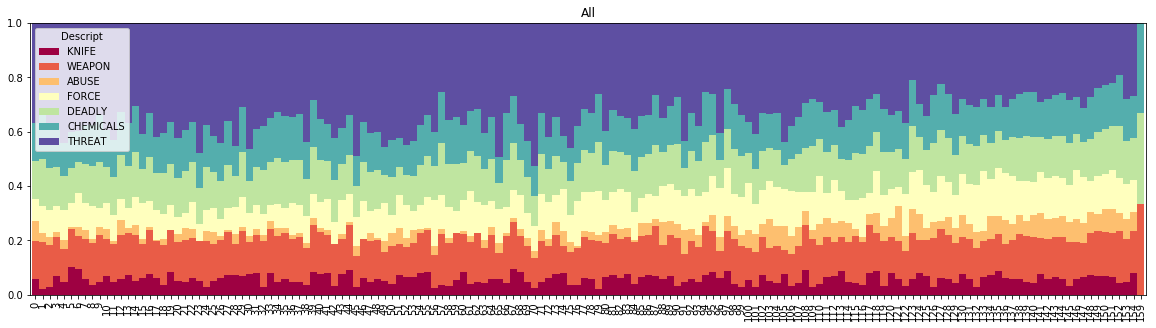

In [306]:
assault_df_all=assault_analysis_rescale(t_all,district,True)

### Focussing on real dates and Districts
#### Let's add the real dates.
#### And focusing on several types of Assaults

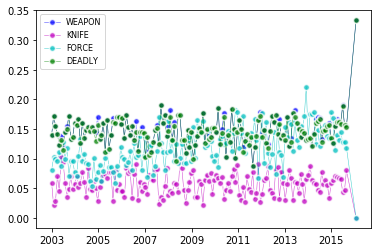

In [307]:
dates_for_plot.index=dates_for_plot
sns.set_context(rc={"figure.figsize": (25.5,5.5)})
for d,c in zip(['WEAPON','KNIFE','FORCE','DEADLY'],['b','m','c','g']):
    plt.plot(dates_for_plot.index,assault_df_all[d],'o-',color=c,ms=6,mew=1.5,mec='white',linewidth=0.5,label=d,alpha=0.75)
plt.legend(loc='upper left',scatterpoints=1,prop={'size':8})

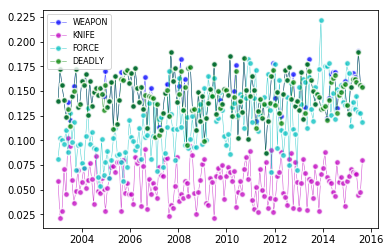

In [308]:
# filter outliers in 2016. To eliminated the outliers, we have put the value of the method 'head' to 155. 
# So that we eliminated on the plot the outliers of the 2016 year.

dates_for_plot.index=dates_for_plot
sns.set_context(rc={"figure.figsize": (25.5,5.5)})
for d,c in zip(['WEAPON','KNIFE','FORCE','DEADLY'],['b','m','c','g']):
    plt.plot(dates_for_plot.head(155).index,assault_df_all[d].head(155),'o-',color=c,ms=6,mew=1.5,mec='white',linewidth=0.5,label=d,alpha=0.75)
plt.legend(loc='upper left',scatterpoints=1,prop={'size':8})

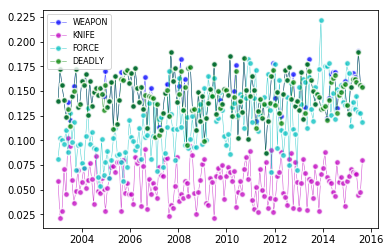

In [309]:
dates_for_plot.index=dates_for_plot
sns.set_context(rc={"figure.figsize": (25.5,5.5)})
for d,c in zip(['WEAPON','KNIFE','FORCE','DEADLY'],['b','m','c','g']):
    plt.plot(dates_for_plot.head(155).index,assault_df_all[d].head(155),'o-',color=c,ms=6,mew=1.5,mec='white',linewidth=0.5,label=d,alpha=0.75)
plt.legend(loc='upper left',scatterpoints=1,prop={'size':8})


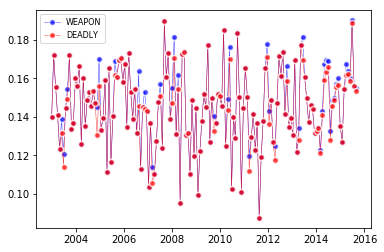

In [310]:
# Eliminate 'KNIFE' and 'FORCE' as it has different range
dates_for_plot.index=dates_for_plot
sns.set_context(rc={"figure.figsize": (25.5,5.5)})
for d,c in zip(['WEAPON','DEADLY'],['b','r','g']):
    plt.plot(dates_for_plot.head(155).index,assault_df_all[d].head(155),'o-',color=c,ms=6,mew=1.5,mec='white',linewidth=0.5,label=d,alpha=0.75)
plt.legend(loc='upper left',scatterpoints=1,prop={'size':8})


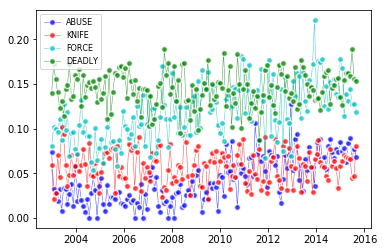

In [311]:
dates_for_plot.index=dates_for_plot
sns.set_context(rc={"figure.figsize": (25.5,5.5)})
for d,c in zip(['ABUSE','KNIFE','FORCE','DEADLY'],['b','r','c','g']):
    plt.plot(dates_for_plot.head(155).index,assault_df_all[d].head(155),'o-',color=c,ms=6,mew=1.5,mec='white',linewidth=0.5,label=d,alpha=0.75)
plt.legend(loc='upper left',scatterpoints=1,prop={'size':8})

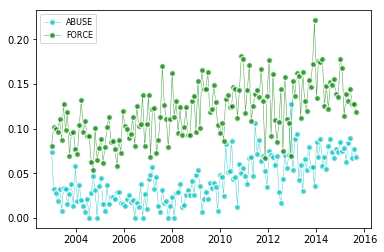

In [312]:
# Examine possible correlation between ABUSE and FORCE
dates_for_plot.index=dates_for_plot
sns.set_context(rc={"figure.figsize": (25.5,5.5)})
for d,c in zip(['ABUSE','FORCE'],['c','g']):
    plt.plot(dates_for_plot.head(155).index,assault_df_all[d].head(155),'o-',color=c,ms=6,mew=1.5,mec='white',linewidth=0.5,label=d,alpha=0.75)
plt.legend(loc='upper left',scatterpoints=1,prop={'size':8})

#### About last plots above, we can do several considerations:

1.	In general, it seems there is a lot of randomization in the annual number of assaults type described.

2.	We can else see an increase in the last years of the assaults crimes of the “ABUSE” and “FORCE” types.

3.  We see an elevated correlation between ‘weapon’ and ‘deadly’ descript. So,  we can deduce that the most of cases where      people have been deadly assault, it has been used a weapon.

4.	We can appreciate a small correlation between “ABUSE” Y “FORCE” types, specifically in last years.  



#### To see more in depth, iterate through each district.

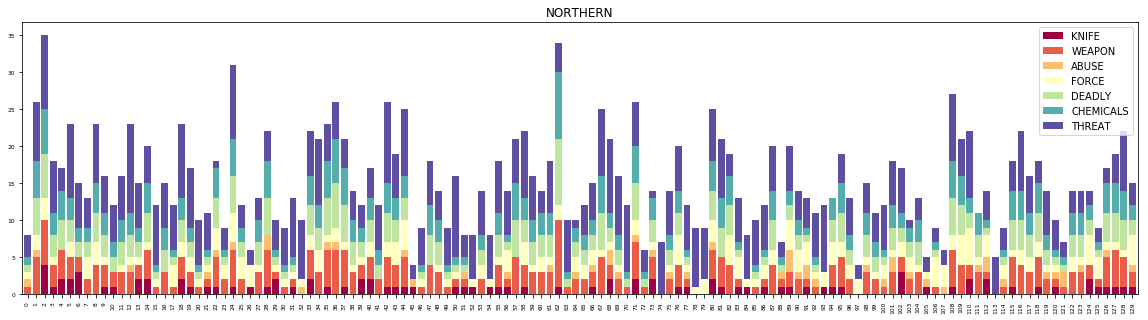

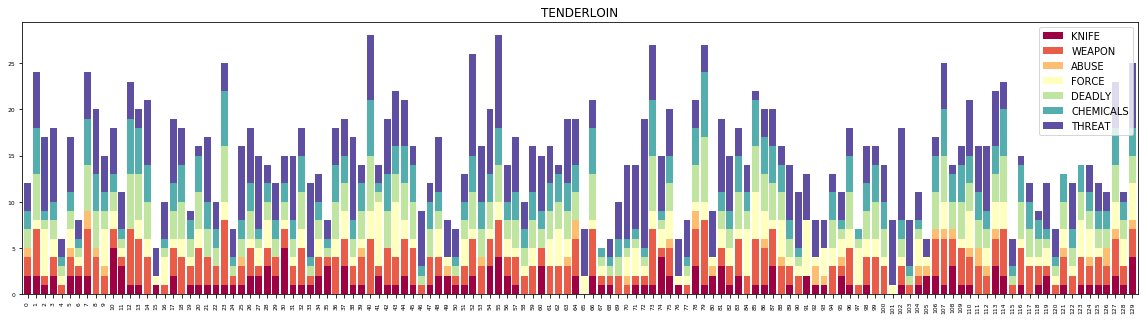

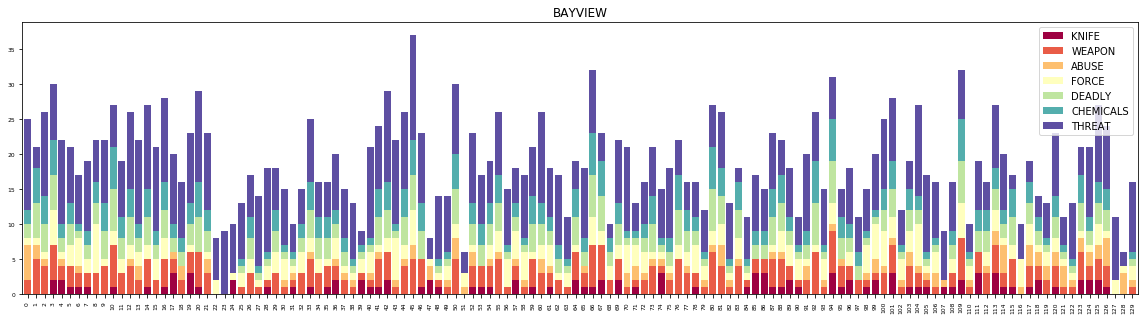

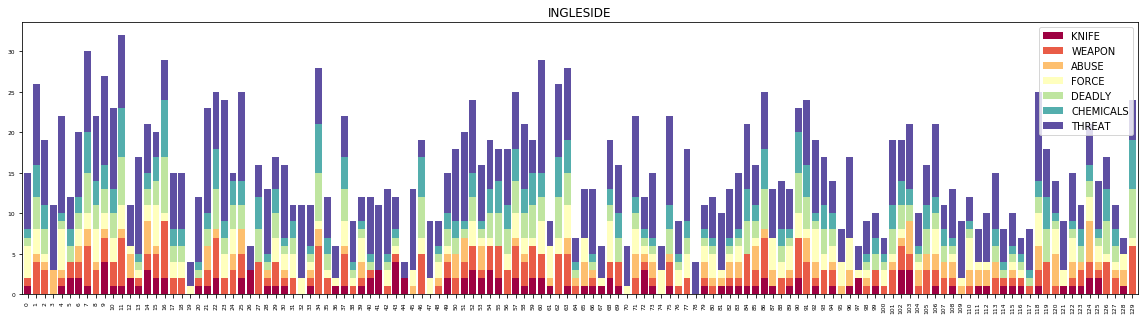

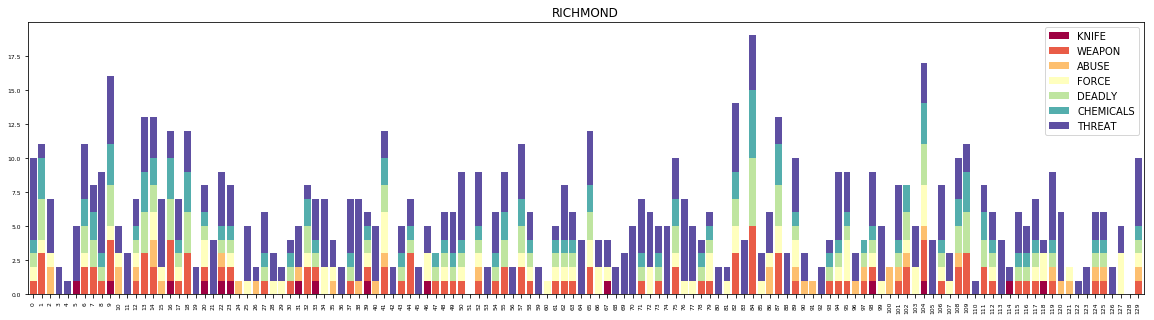

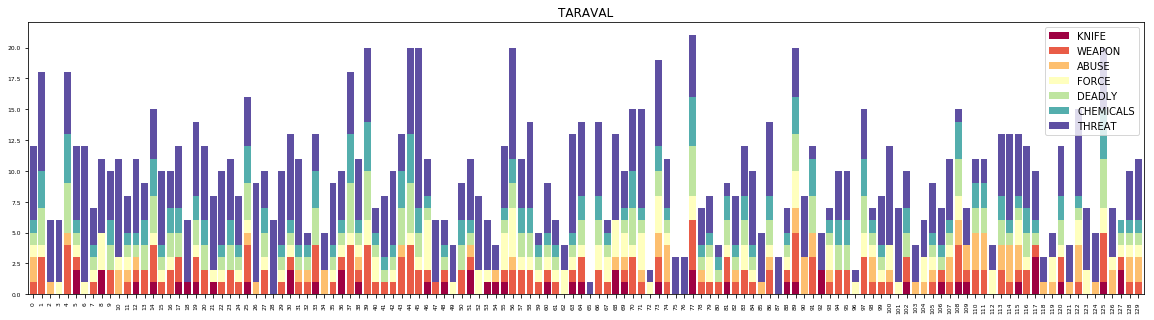

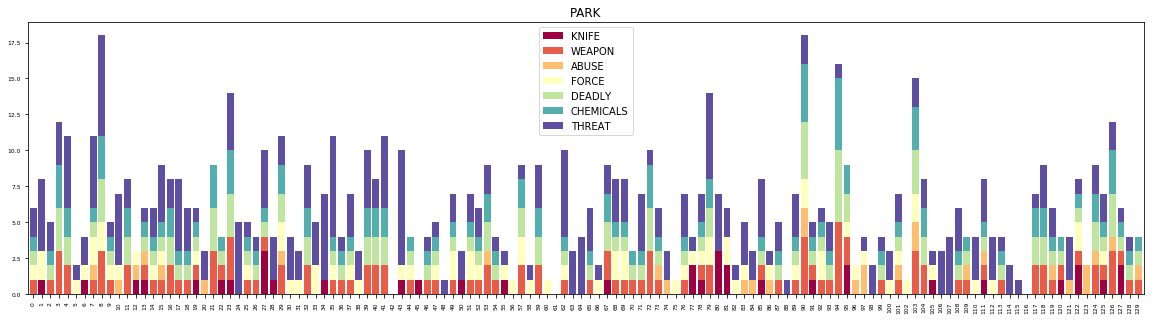

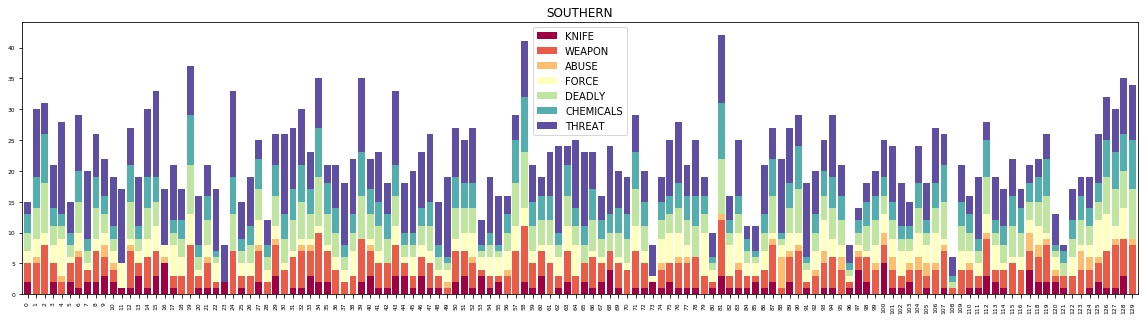

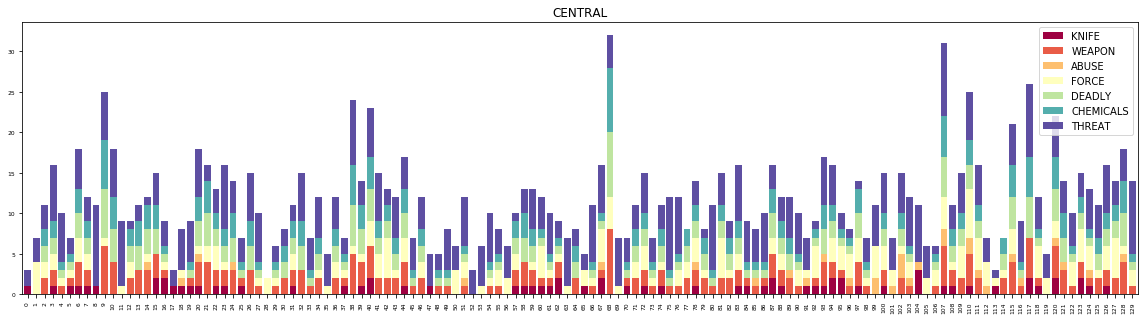

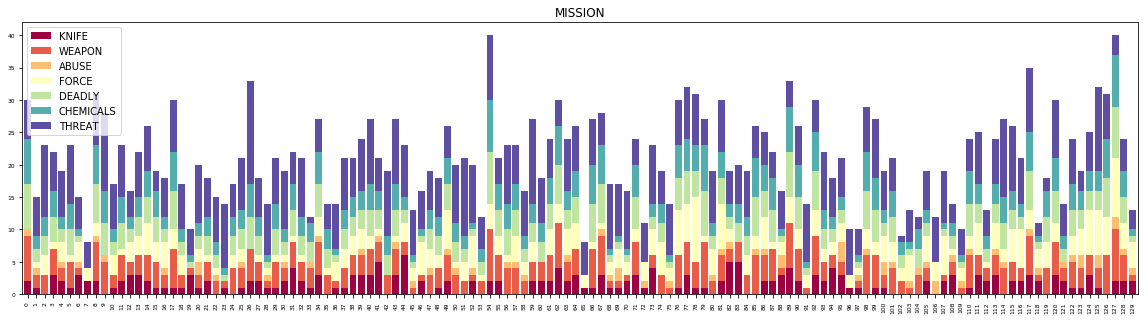

In [313]:
# Analytics per assault tipology according to descriptions by months and district, with absolute values. 
# We've eliminated outliners of the 2016 year. 

stor=[]
stor_time=[]

for d in set(d_crime['PdDistrict']):
    # Specify district and group by time
    dist_dat=df2[df2['PdDistrict']==d]
    t=timeseries(dist_dat,0)
    # Merge to ensure all categories are preserved!
    t_merge=pd.DataFrame(columns=t_all.columns)
    m=pd.concat([t_merge,t],axis=0).fillna(0)
    m.reset_index(inplace=True)
    # Plot
    assault_df=assault_analysis(m,d,True)
    plt.show(plt.cm.RdYlGn)
    s=assault_df.sum(axis=0)
    stor=stor+[s]
    assault_df.columns=cols=[c+"_%s"%d for c in assault_df.columns]
    stor_time=stor_time+[assault_df]
    
assault_dat_time=pd.concat(stor_time,axis=1)
assault_dat=pd.concat(stor,axis=1)
assault_dat.columns=[list(set(d_crime['PdDistrict']))]

### Let's perform Correlation Analysis

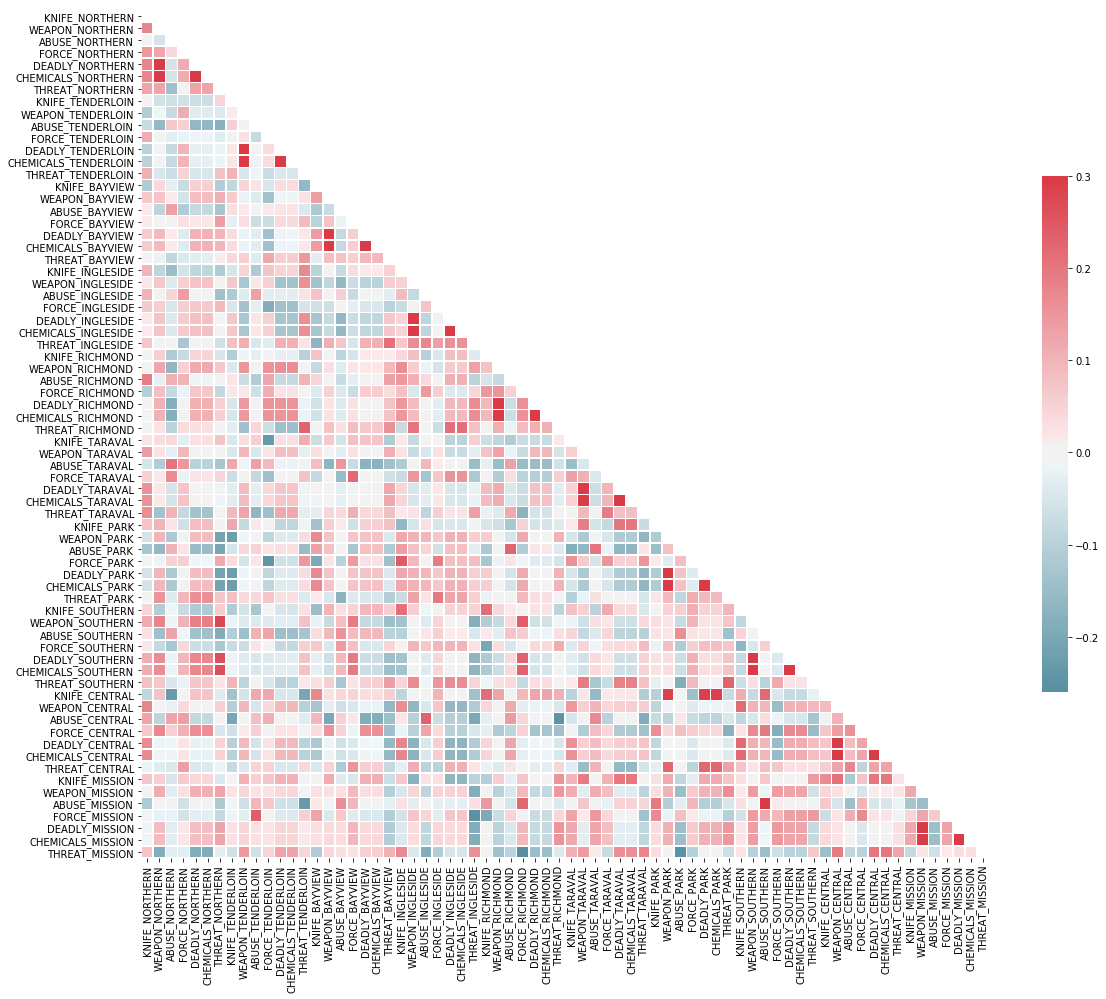

In [314]:
##We can also look at correlations between areas for different assaults.

sns.set_context(rc={"figure.figsize": (20,20)})
corr = assault_dat_time.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(19, 19))

# Generate a custom diverging colormap
sns.set_context(rc={"figure.figsize": (20,20)})
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Plot the correlation heatmap
sns.heatmap(corr,  mask=mask, cmap=cmap, vmax=0.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": 0.5})

##### Correlation Analysis

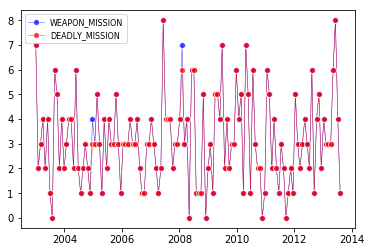

In [315]:
#With this in mind, we can examine select timeseries data.
#Exist an elevated correlation between both attributes.

assault_dat_time.index=dates_for_plot.head(130)
sns.set_context(rc={"figure.figsize": (7.5,5)})
for d,c in zip(['WEAPON_MISSION','DEADLY_MISSION'],['b','r']):
    plt.plot(assault_dat_time.index,assault_dat_time[d],'o-',color=c,ms=6,mew=1,mec='white',linewidth=0.5,label=d,alpha=0.75)
plt.legend(loc='upper left',scatterpoints=1,prop={'size':8})

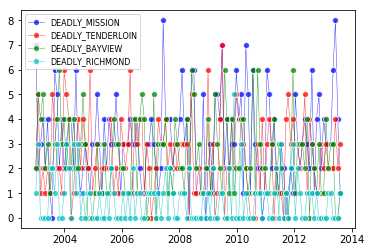

In [316]:

assault_dat_time.index=dates_for_plot.head(130)
sns.set_context(rc={"figure.figsize": (7.5,5)})
for d,c in zip(['DEADLY_MISSION','DEADLY_TENDERLOIN','DEADLY_BAYVIEW','DEADLY_RICHMOND'],['b','r','g','c']):
    plt.plot(assault_dat_time.index,assault_dat_time[d],'o-',color=c,ms=6,mew=1,mec='white',linewidth=0.5,label=d,alpha=0.75)
plt.legend(loc='upper left',scatterpoints=1,prop={'size':8})

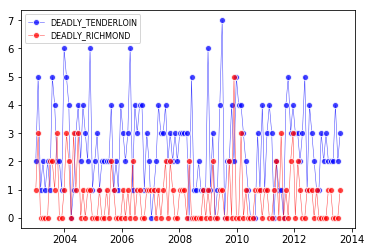

In [317]:
# In this plot, we can see the difference in the number of deadly assaults between two districts.
# We have more deadly assaults in Tenderloin District than Richmon District 
# and curiously The Tenderloin District is poorer than Richmon district.

assault_dat_time.index=dates_for_plot.head(130)
sns.set_context(rc={"figure.figsize": (7.5,5)})
for d,c in zip(['DEADLY_TENDERLOIN','DEADLY_RICHMOND'],['b','r','g','c']):
    plt.plot(assault_dat_time.index,assault_dat_time[d],'o-',color=c,ms=6,mew=1,mec='white',linewidth=0.5,label=d,alpha=0.75)
plt.legend(loc='upper left',scatterpoints=1,prop={'size':8})

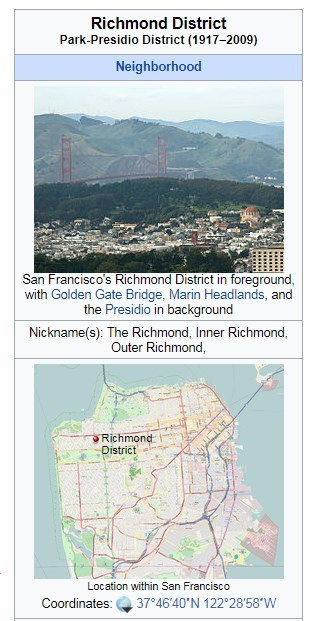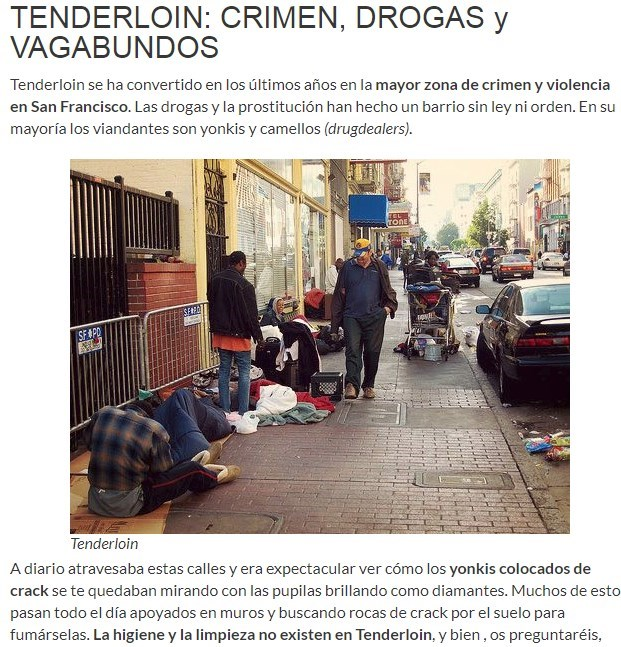

### Now we examine Spatial Relationships

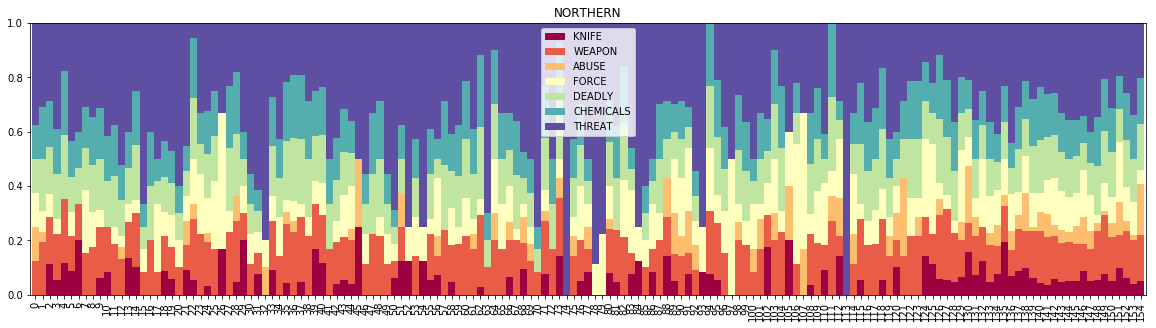

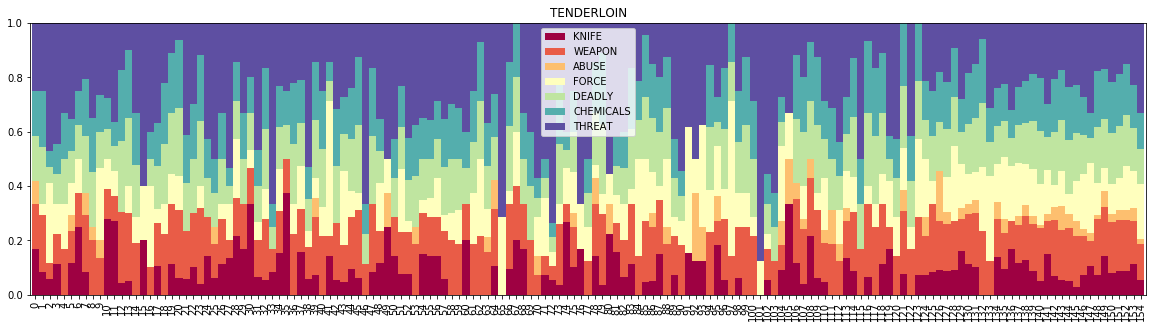

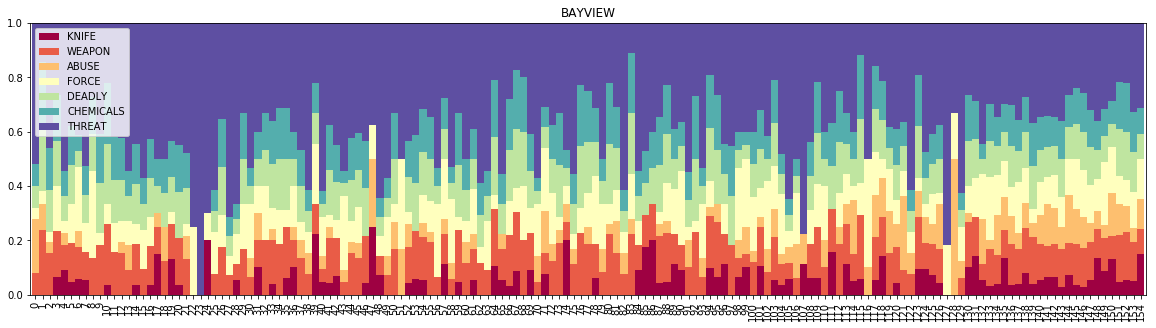

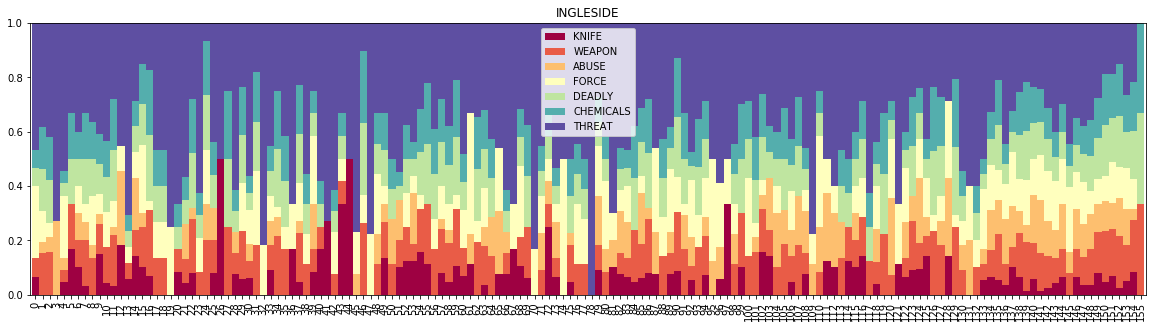

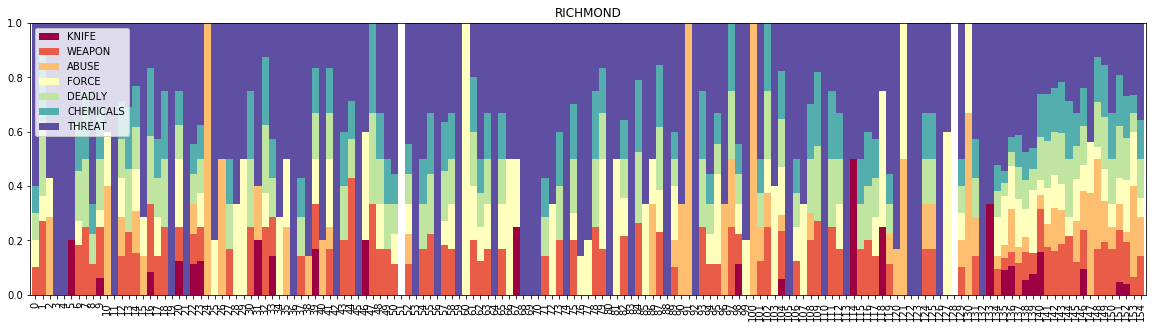

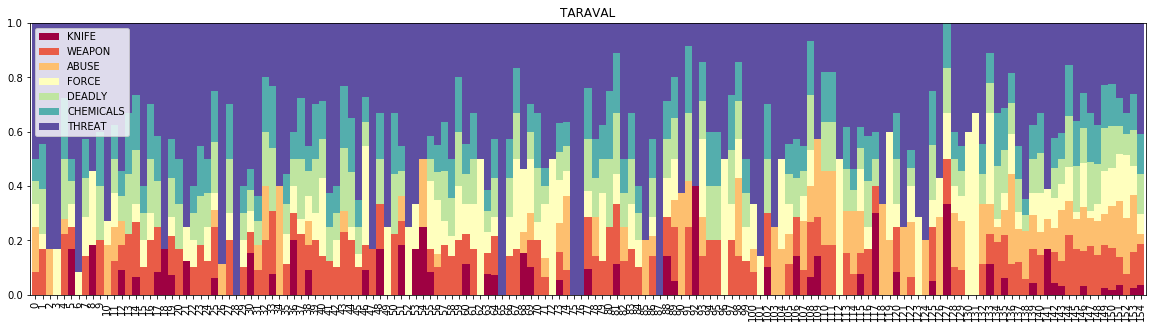

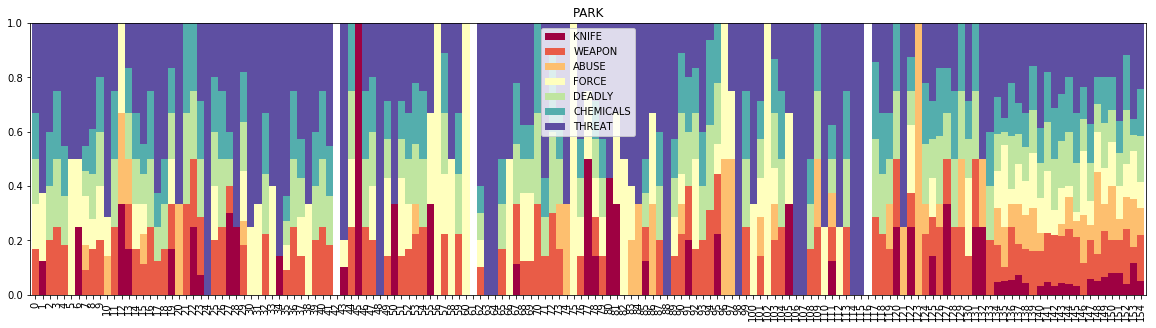

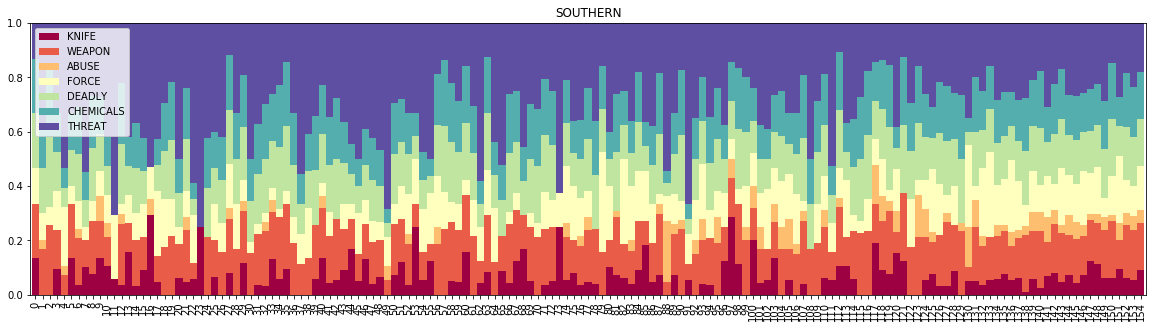

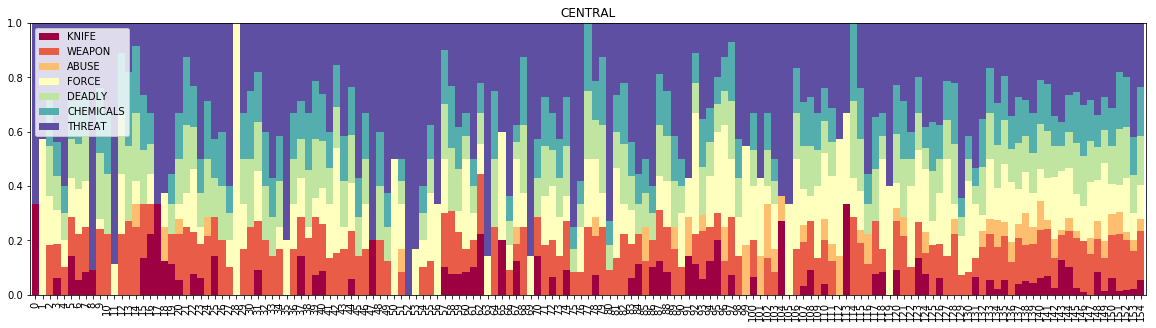

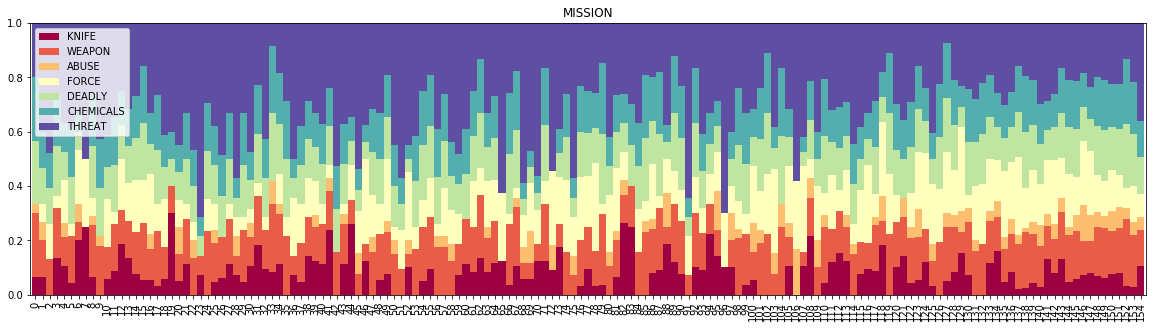

In [318]:
#Let's re-do what we did above, but re-scale it.

stor=[]
stor_time=[]

for d in set(d_crime['PdDistrict']):
    # Specify district and group by time
    dist_dat=df2[df2['PdDistrict']==d]
    t=timeseries(dist_dat,0)
    # Merge to ensure all categories are preserved!
    t_merge=pd.DataFrame(columns=t_all.columns)
    m=pd.concat([t_merge,t],axis=0).fillna(0)
    m.reset_index(inplace=True)
    # Plot
    assault_df=assault_analysis_rescale(m,d,True)
    plt.show()
    s=assault_df.sum(axis=0)
    stor=stor+[s]
    assault_df.columns=cols=[c+"_%s"%d for c in assault_df.columns]
    stor_time=stor_time+[assault_df]
    
assault_dat_time_rescale=pd.concat(stor_time,axis=1)
assault_dat_rescale=pd.concat(stor,axis=1)
assault_dat.columns=[list(set(d_crime['PdDistrict']))]

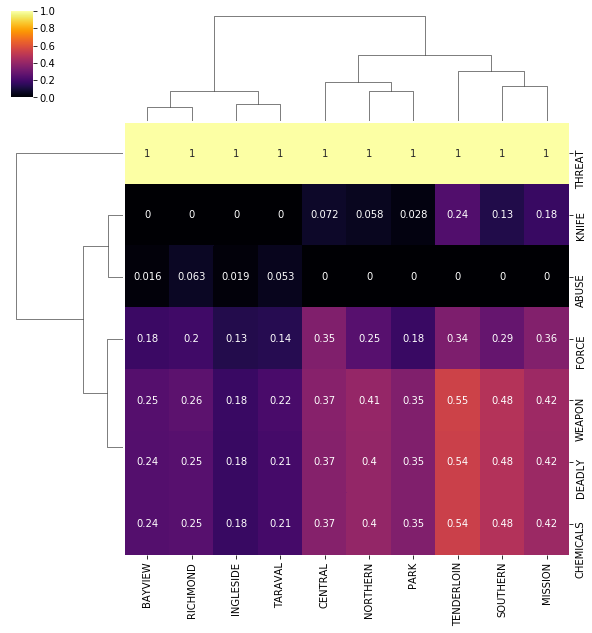

In [319]:
#We can now summarize this data using clustered heatmaps. 
#Here we can see clearly the different assaults type selected by districts and compare it between them.

sns.clustermap(assault_dat,standard_scale=1,cmap="inferno",robust=True,annot=True)

#### Mapping relationships

In [320]:
#Let's isolate all deadly-related records.

tmp=df2.copy()
tmp.set_index('Descript',inplace=True)

deadly_dat=tmp.loc[deadly_features]
deadly_pts=deadly_dat[['X','Y','Month']]

In [321]:
#Plot the deadly regimes.

d=pd.DataFrame(deadly_pts.groupby('Month').size())
d.index=dates_for_plot.head(156)
d.columns=['Count']
diff=len(d.index)-120

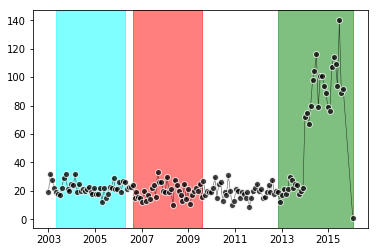

In [322]:
plt.plot(d.index,d['Count'],'o-',color='k',ms=6,mew=1,mec='white',linewidth=0.5,label=d,alpha=0.75)
plt.axvspan(d.index[40-diff],d.index[40],color='cyan',alpha=0.5)
plt.axvspan(d.index[80-diff],d.index[80],color='red',alpha=0.5)
plt.axvspan(d.index[120],d.index[-1],color='green',alpha=0.5)

In [323]:
oldest_deadly_sums=d.loc[(d.index>d.index[40-diff]) & (d.index<d.index[40])]
old_deadly_sums=d.loc[(d.index>d.index[80-diff]) & (d.index<d.index[80])]
new_deadly_sums=d.loc[d.index>d.index[120]]

In [324]:
#Fold-difference in mean between the two regimes.
old_deadly_sums['Count'].mean()/float(new_deadly_sums['Count'].mean())

0.3033259423503326

In [325]:
#Two regimes.

oldest_deadly=deadly_pts[(deadly_pts['Month']>(40-diff)) & (deadly_pts['Month']<40)]
oldest_deadly.columns=['longitude','latitude','time']
old_deadly=deadly_pts[(deadly_pts['Month']>(80-diff)) & (deadly_pts['Month']<80)]
old_deadly.columns=['longitude','latitude','time']
new_deadly=deadly_pts[deadly_pts['Month']>120]
new_deadly.columns=['longitude','latitude','time']

### We can look at this spatially.
###### Use a shapefile for Neighborhoods in SF to overlay the data onto a map.
###### https://data.sfgov.org/Geographic-Locations-and-Boundaries/Neighborhoods/ejmn-jyk6
###### Basemap can be used to view this. Some nice work at this link that I drew from:
###### http://sensitivecities.com/so-youd-like-to-make-a-map-using-python-EN.html

In [326]:
# Let's create MongoBD collections to manage and query data. we create two collections.
col1 = db.deadlyo
col2 = db.deadlyn
#Import data into the database
col1.drop()
col2.drop()

In [327]:
# Collection for new deadly
data_json1 = json.loads(new_deadly.to_json(orient='records'))
col1.delete_many({})
col1.insert_many(data_json1)

In [328]:
# Collection for old deadly
data_json2 = json.loads(old_deadly.to_json(orient='records'))
col2.delete_many({})
col2.insert_many(data_json2)

In [329]:
#Check if you can access the data from the MongoDB.
cursor = col1.find().sort('time',pymongo.ASCENDING).limit(3)
for doc in cursor:
    print(doc)

{'_id': ObjectId('5a58a9c91c87e2096cc4f7d7'), 'longitude': -122.420996914, 'latitude': 37.7831032669, 'time': 121.0}
{'_id': ObjectId('5a58a9c91c87e2096cc4f7ea'), 'longitude': -122.4218764885, 'latitude': 37.7640888945, 'time': 121.0}
{'_id': ObjectId('5a58a9c91c87e2096cc4f7f9'), 'longitude': -122.411778296, 'latitude': 37.7839805593, 'time': 121.0}


In [330]:
cursor2 = col2.find().sort('time',pymongo.ASCENDING).limit(10)
for doc in cursor2:
    print(doc)

{'_id': ObjectId('5a58a9ca1c87e2096cc4f98b'), 'longitude': -122.3934117356, 'latitude': 37.7202363012, 'time': 45.0}
{'_id': ObjectId('5a58a9ca1c87e2096cc4f9c7'), 'longitude': -122.4184481861, 'latitude': 37.7522391653, 'time': 45.0}
{'_id': ObjectId('5a58a9ca1c87e2096cc4f9db'), 'longitude': -122.3881701151, 'latitude': 37.7669571296, 'time': 45.0}
{'_id': ObjectId('5a58a9ca1c87e2096cc4fa10'), 'longitude': -122.3987864314, 'latitude': 37.7933601124, 'time': 45.0}
{'_id': ObjectId('5a58a9ca1c87e2096cc4fa2d'), 'longitude': -122.4129705376, 'latitude': 37.7857883767, 'time': 45.0}
{'_id': ObjectId('5a58a9ca1c87e2096cc4fa53'), 'longitude': -122.3900198447, 'latitude': 37.7192987553, 'time': 45.0}
{'_id': ObjectId('5a58a9ca1c87e2096cc4fa7a'), 'longitude': -122.47819194, 'latitude': 37.7635138827, 'time': 45.0}
{'_id': ObjectId('5a58a9ca1c87e2096cc4fa7b'), 'longitude': -122.4144060299, 'latitude': 37.7841907151, 'time': 45.0}
{'_id': ObjectId('5a58a9ca1c87e2096cc4fa93'), 'longitude': -122.40

In [331]:
# Create a new collection to store districts geo points
col3 = db.districts
col3.drop()

In [332]:
# mongoBD import from geojson file containing geopoints in form of multipopygons
os.system('"C:\\Program Files\\MongoDB\\Server\\3.4\\bin\\mongoimport" -d test -c districts --file F:\\CaseUseIData\\Analysis_Neighborhoods.geojson')

0

In [333]:
cursor3 = col3.find().limit(1)
for doc in cursor3:
    print(doc)

{'_id': ObjectId('5a58a9cb9ff6bc04ad30b692'), 'type': 'FeatureCollection', 'features': [{'type': 'Feature', 'properties': {'nhood': 'Bayview Hunters Point'}, 'geometry': {'type': 'MultiPolygon', 'coordinates': [[[[-122.38157774241415, 37.75307043091241], [-122.38156949251606, 37.753060959298274], [-122.38159239626694, 37.75309424492931], [-122.38155614326205, 37.753045901366754], [-122.38155137472305, 37.75304127677009], [-122.38154650687193, 37.753036719547374], [-122.3815415385967, 37.75303223061754], [-122.38153647334677, 37.75302781172802], [-122.38153131112232, 37.75302346287867], [-122.38152605423795, 37.753019185835115], [-122.38152070389688, 37.75301498328154], [-122.38151526236827, 37.75301085518192], [-122.38150973196667, 37.75300680330162], [-122.38150411158058, 37.75300282855954], [-122.38149840577098, 37.7529989317842], [-122.38149261460651, 37.75299511567804], [-122.38148674033339, 37.75299137930393], [-122.38148078528907, 37.75298772532827], [-122.38147475063121, 37.7529

In [334]:
# Get information about the index
col2.index_information()

{'_id_': {'key': [('_id', 1)], 'ns': 'test.deadlyn', 'v': 2}}

#### Prepare data to perform spatial queries by Mongo

In [335]:
col_temp = db.crackn2
cursor = col2.find()
for doc in cursor:
    col_temp.insert_one({
        "loc": {
            "type": "Point",
            "coordinates": [doc["longitude"], doc["latitude"]]
        }
    });

In [336]:
cursor = col_temp.find().limit(10)
for doc in cursor:
    print(doc)

{'_id': ObjectId('5a3427cf1c87e2354c5f08b2'), 'loc': {'type': 'Point', 'coordinates': [-122.4170853574, 37.785215359]}}
{'_id': ObjectId('5a3427cf1c87e2354c5f08b3'), 'loc': {'type': 'Point', 'coordinates': [-122.4129705376, 37.7857883767]}}
{'_id': ObjectId('5a3427cf1c87e2354c5f08b4'), 'loc': {'type': 'Point', 'coordinates': [-122.4196583437, 37.7642205604]}}
{'_id': ObjectId('5a3427cf1c87e2354c5f08b5'), 'loc': {'type': 'Point', 'coordinates': [-122.4142178043, 37.7832593295]}}
{'_id': ObjectId('5a3427cf1c87e2354c5f08b6'), 'loc': {'type': 'Point', 'coordinates': [-122.4279850935, 37.7723641437]}}
{'_id': ObjectId('5a3427cf1c87e2354c5f08b7'), 'loc': {'type': 'Point', 'coordinates': [-122.4210578548, 37.7665987781]}}
{'_id': ObjectId('5a3427cf1c87e2354c5f08b8'), 'loc': {'type': 'Point', 'coordinates': [-122.4109552489, 37.784139951]}}
{'_id': ObjectId('5a3427cf1c87e2354c5f08b9'), 'loc': {'type': 'Point', 'coordinates': [-122.4113395626, 37.7812707434]}}
{'_id': ObjectId('5a3427cf1c87e235

In [337]:
cursor2 = col2.find_one()   

In [338]:
query = {"features.geometry": 
    { "$geoIntersects": 
                { "$geometry": 
                    {"type": "Point", 
                     "coordinates": [cursor2["longitude"],cursor2["latitude"]] 
                    }
                } 
            } 
        }

In [339]:
cursor3 = col3.find_one(query)

In [340]:
# Generate new collection with features filteres
collection_features = db.feat
collection_features.delete_many({})
collection_features.insert_many(cursor3["features"])

In [341]:
# Obtain cursor
cursor4 = collection_features.find_one()

In [342]:
# Spatial query implementing getoIntersects operation
query_feat = {"geometry": 
                { "$geoIntersects": 
                { "$geometry": 
                    {"type": "Point", 
                     "coordinates": [cursor2["longitude"],cursor2["latitude"]] 
                    }
                } 
            } 
        }

In [343]:
# Have a look if every thing is OK
for doc in collection_features.find(query_feat):
    print(doc)

{'_id': ObjectId('5a58a9cc1c87e2096cc4fe9c'), 'type': 'Feature', 'properties': {'nhood': 'Haight Ashbury'}, 'geometry': {'type': 'MultiPolygon', 'coordinates': [[[[-122.43199799957345, 37.771430999654044], [-122.4319039996054, 37.77096400026347], [-122.43181099947442, 37.770501000231846], [-122.43171699946927, 37.77003500010839], [-122.4315699996006, 37.769307000353685], [-122.43246400046051, 37.76925000004985], [-122.43357199969519, 37.76917800037881], [-122.43489300016078, 37.76911400000589], [-122.43579400046521, 37.769058000421104], [-122.43658799949046, 37.769000999573514], [-122.43710600014384, 37.76896300020424], [-122.43723099966391, 37.76906000015318], [-122.43755600043151, 37.769043000278955], [-122.43833800004029, 37.769007000382004], [-122.43881999954209, 37.7684009998967], [-122.43930099996568, 37.768166000067936], [-122.44013699954324, 37.767757000167826], [-122.44060400056635, 37.76695500019391], [-122.44193800020228, 37.76595299963987], [-122.44200900004391, 37.76590700

In [344]:
# Obtain the selected neighborhood
cursor_feat = collection_features.find_one(query_feat)
print(cursor_feat["properties"])

{'nhood': 'Haight Ashbury'}


### Printing data in Maps

In [345]:
# Set general coordinates of San Francisco city
SF_COORDINATES = (37.76, -122.45) ## San Francisco Coordinates

In [346]:
MAX_RECORDS = 100
m = folium.Map(location=SF_COORDINATES, zoom_start=12)

In [347]:
#Display neighborhoods by polygons
geo_json_data = json.load(open('F:\\CaseUseIData\\Analysis_Neighborhoods.geojson'))
folium.GeoJson(geo_json_data).add_to(m)

In [348]:
# Display Old deadly points (Red)
cursor = col1.find().limit(MAX_RECORDS)
for doc in cursor:
    folium.Marker(location = [doc["latitude"],doc["longitude"]],
                  popup='Old deadly',
                  icon=folium.Icon(color='red')).add_to(m)

In [349]:
# Display New deadly Points (Green)
cursor = col2.find().limit(MAX_RECORDS)
for doc in cursor:
    folium.Marker(location = [doc["latitude"],doc["longitude"]],
                  popup='New deadly',
                  icon=folium.Icon(color='green')).add_to(m)

In [350]:
# Display queried point in spatial query (Blue)
folium.Marker(location = [cursor2["latitude"],cursor2["longitude"]],
                  popup='Selected Point',
                  icon=folium.Icon(color='blue')).add_to(m)

In [351]:
folium.LayerControl().add_to(m)

In [352]:
m.save(outfile='F:\\CaseUseIData\\map1.html')

In [353]:
m

In [354]:
%%HTML
<iframe width="100%" height="350" src="file:///F://CaseUseIData//map1.html?inline=true"></iframe>

In [355]:
# Obtaining the geometry of an Incident

In [356]:
map2 = folium.Map(location=SF_COORDINATES, zoom_start=12)

In [357]:
folium.GeoJson(
    cursor_feat["geometry"],
    name='Selected Neighborhood'
).add_to(map2)

In [358]:
folium.Marker(location = [cursor2["latitude"],cursor2["longitude"]],
                  popup='Selected Point',
                  icon=folium.Icon(color='blue')).add_to(map2)

In [359]:
folium.LayerControl().add_to(map2)

In [360]:
map2.save(outfile='F:\\CaseUseIData\\map2.html')

In [361]:
map2